$$\Large \textbf{Loading Data}$$

-------

In [1]:
from iv2_utils.iv2 import pickle_read, pickle_write
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from tabulate import tabulate
from jar.config import *
import pandas as pd
import numpy as np
import pickle
import pandas
import copy
import cv2
import os

In [2]:
data = load_data()

In [26]:
logits_r = pickle_read('rustyjar/InternVideo-logits-r.pkl')
logits_a = pickle_read('rustyjar/InternVideo-logits-a.pkl')
logits_g = pickle_read('rustyjar/InternVideo-logits-g.pkl')
logits_lg = pickle_read('rustyjar/InternVideo2-logits-g.pkl')
logits_r_xclip = pickle_read('rustyjar/XCLIP-logits-r.pkl')
logits_r_smol = pickle_read('rustyjar/IVS-logits-r.pkl')
logits_a_smol = pickle_read('rustyjar/IVS-logits-r.pkl')
logits_r2 = pickle_read('rustyjar/InternVideo2-logits-r.pkl')
logits_l14_g = pickle_read('rustyjar/InternVideoL-logits-g.pkl')
logits_b14_r = pickle_read('rustyjar/InternVideoB-logits-r.pkl')
logits_b14_g = pickle_read('rustyjar/InternVideoB-logits-g.pkl')
logits_b14_a = pickle_read('rustyjar/InternVideoB-logits-a.pkl')

raw_data = pandas.read_csv('anno_backflip.csv')
data_k600 = []
for index, row in raw_data.iterrows():
    data_k600.append((row['ID'], eval('[' + row['Frame(s)'] + ']')))

data_gif87 = pickle_read('rustyjar/GIF87.pkl')

print(len(IV_a8), 'predictions loaded.')
print("First 10 Predictions from Intern Video:      ", IV_a8[:10])
print("First 10 predictions from CLIP:              ", CLIP_a[:10])
print("-"*50)
print("First 10 actual values:", [x[1] for x in data_k600[:10]])

FileNotFoundError: [Errno 2] No such file or directory: 'rustyjar/InternVideo-logits-r.pkl'

In [39]:
def logitToPred(logit_lists, window_size = 8):
    result = []
    for logits in logit_lists:
        logits_c = copy.deepcopy(logits)
        logits_c.sort(key = lambda x: x[1])
        new_logits = []
        add = (window_size -8) // 2
        for j in range(add, len(logits_c) - add):
            a_range = list(range(j - add, j + add + 1))
            a_range = [logits_c[x][0] for x in a_range]
            new_logits.append((np.mean(a_range).item(), j + 1))
            # new_logits.append((logits_c[j][0], j + 1))
        # print(new_logits)
        # print("---"*10)
        # print(logits_c)
        new_logits.sort(key = lambda x: -x[0])
        if len(new_logits) == 0:
            new_logits.append((0, 4))
        result.append(new_logits[0][1])
    return result
# test = logitToPred(logits_a_smol, window_size = 13)
j = [8] + list(range(11, 21, 2))
for ws in j:
    pickle_write(logitToPred(pickle_read('rustyjar/ViCLIP/s.pkl'), window_size = ws), f'jar/ViCLIP/s{ws}.pkl')
    print("Done with size",ws)
# test = logitToPred(logits_g, window_size = 11)
# pickle_write(logitToPred(logits_g, window_size = 17), 'jar/InternVideo-g17.pkl')

Done with size 8
Done with size 11
Done with size 13
Done with size 15
Done with size 17
Done with size 19


$$\Large \textbf{Reading Logits and Averaging Predictions}$$

------

In [ ]:
IV_g100 = []
for idx, p11 in enumerate(IVB_r8):
    p13 = IVB_r11[idx]
    p15 = IVB_r13[idx]
    IV_g100.append((p11+p13+p15)//3)
pickle_write(IV_g100, 'jar/InternVideoB-r100.pkl')

In [ ]:
correct = pickle_read('rustyjar/GIF87.pkl')
print(correct[-5:])

In [ ]:
data_gif87

In [ ]:
IV_L14_g = [22, 1, 24, 4, 4, 15, 18, 55, 30, 14, 59, 64, 10, 49, 292, 154, 138, 7, 139, 218, 4, 143, 40, 33, 24, 3, 1, 20, 12, 8, 1, 10, 7, 7, 53, 10, 15, 79, 143, 13, 32, 4, 225, 15, 9, 283, 30, 49, 15, 55, 11, 2, 11, 5]

In [ ]:
IV_g13 = []
logits_37 = []
for idx, logits in enumerate(logits_g):
    logits_sort = copy.deepcopy(logits)

    avg_logits = []

    for i in range(2, len(logits) - 2):
        if idx == 37:
            logits_37.append((sum([logits[x][0] for x in [i - 2, i - 1, i, i + 1, i + 2]])/5, i + 1))
        avg_logits.append((sum([logits[x][0] for x in [i - 2, i - 1, i, i + 1, i + 2]])/5, i + 1))
    
    avg_logits.sort(key = lambda x: -x[0])
    IV_g13.append(avg_logits[0][1])
    

print(IV_g13[-5:])
pickle_write(IV_g13, 'jar/InternVideo-g13.pkl')

In [ ]:
print(IV_a100[38])
plt.figure(figsize=[3, 2])
plt.plot([x[1] for x in logits_a[38]], [x[0] for x in logits_a[38]], linewidth=2)
plt.xlabel("Frame Index")
plt.ylabel("Similarity Score")

plt.gca().set_position([0, 0, 1, 1])
plt.savefig('frame-similarity-score.svg', bbox_inches="tight")

plt.show()

$$\Large \mathbf{1}^{\text{st}}\text{ Metric}$$

--------

In [3]:
def showMetric(preds, data, threshold = 8, compare = False):
    def clamp_error(prediction, truth): # NN's Idea
        if truth in range(prediction, prediction + 9):
            return 0
        else: 
            return (prediction + 8) - truth if truth > prediction + 8 else prediction - truth
    
    score = 0
    offsets = []
    for idx, i_pred in enumerate(preds):
        within_range = False
        off = 10000
        for truth in data[idx][1]:
            if abs(i_pred - truth) < abs(off):
                off = i_pred - truth
    
            if abs(i_pred - truth) <= threshold:
                within_range = True
        
        if within_range:
            score += 1
    
        offsets.append(off)
    
    score = score / len(data)
    # print(f"Accuracy with |error| <= {threshold}:",'{}%'.format(round(score*100, 2)))

    return score

In [11]:
showMetric(data.ViCLIP('stock100', 8), data.stock100, threshold=100)

1.0

/var/folders/zx/46y7zv8x5gd6xfp0s16kr0w00000gp/T/ipykernel_35180/1744068092.py:10: MatplotlibDeprecationWarning: Passing label as a length 100 sequence when plotting a single dataset is deprecated in Matplotlib 3.9 and will error in 3.11.  To keep the current behavior, cast the sequence to string before passing.
  plt.plot(j, label = compare[i])


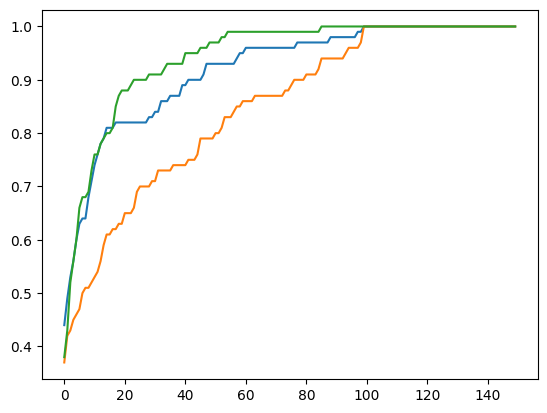


Benchmarks --------------------
8f | 68.00%
8f | 51.00%
8f | 69.00%
-------------------------------
16f | 81.00%
16f | 62.00%
16f | 81.00%
-------------------------------


In [4]:
compare = [data.ViCLIP('stock100', 8), data.CLIP('stock100', 1), data.B14('stock100', 8)]
comp_data = data.stock100

plot_data = eval(str([[]] * len(compare)))
for test_threshold in range(150):
    for idx, preds in enumerate(compare):
        plot_data[idx].append(showMetric(preds, comp_data, threshold=test_threshold))

for i, j in enumerate(plot_data):
    plt.plot(j, label = compare[i])
# plt.legend()
plt.show()

print("\nBenchmarks " + "-"*20)

# maxLen = max([len(x) for x in compare])
for preds in compare:
    count = showMetric(preds, comp_data, threshold=8)
    print("8f","|", f"{count*100:.2f}%")
print("-" * 31)
for preds in compare:
    count = showMetric(preds, comp_data, threshold=16)
    print("16f","|", f"{count*100:.2f}%")
print("-" * 31)

In [ ]:
norm_scale = []
for video_path in tqdm([os.path.join('backflip', x) for x in os.listdir('backflip')]):
    cap = cv2.VideoCapture(video_path)

    frame_num = 0
    success, frame = cap.read()
    while success:
        frame_num += 1
        success, frame = cap.read()
    cap.release()
    
    norm_scale.append(1 / frame_num)

print(norm_scale[:5])

$$\Large \mathbf{2}^{\text{nd}}\text{ Metric}$$

--------

In [5]:
import matplotlib.pyplot as plt
import numpy as np

# Find closest peak
def findClosest(pred, truths):
    dist = 1000000
    peak = -1
    for i in truths:
        if abs(i - pred) < dist:
            dist = abs(i - pred)
            peak = i
    return peak

def showMetric2(preds, data):
    def clamp_error(prediction, truth): # NN's Idea
        if truth in range(prediction, prediction + 9):
            return 0
        else: 
            return (prediction + 8) - truth if truth > prediction + 8 else prediction - truth
    
    mse = []
    for idx, i_pred in enumerate(preds):
        # peak = findClosest(i_pred, data[idx][1]) * norm_scale[idx]
        peak = findClosest(i_pred, data[idx][1])
        # mse.append(abs((i_pred * norm_scale[idx]) - peak)) # Calculating MAE??
        mse.append(abs(i_pred - peak)) # Calculating MAE??
    
    return mse

def find_best_offset(preds, data):
    total = []
    min_val = float('inf')
    min_result = -1
    for l in [x/100 for x in range(-3000, 3000, 1)]:
        mse = calculateMSE([x + l for x in preds], data)
        total.append((l, mse))
        if mse < min_val:
            min_val = mse
            min_result = l
    return min_result

def offset(preds, data):
    best_off = find_best_offset(preds, data)
    return [x + best_off for x in preds]

def calculateMSE(preds, data):
    errors = []
    for idx, i_pred in enumerate(preds):
        new_pred = i_pred + 0
        peak = findClosest(new_pred, data[idx][1])
        errors.append(abs(new_pred - peak) ** 2)
    return np.mean(errors).item()

In [ ]:
data_k600[4]

In [ ]:
showCLIP = False
filter_vals = 'r'

data_use = data_gif87 if filter_vals == 'g' else data_k600

fig, ax = plt.subplots(figsize=(12, 4))

def isCLIP(label):
    return 'CLIP' in label and 'XCLIP' not in label

def extract_digits(input_string):
    digits = ''.join([char for char in input_string if char.isdigit()])
    return int(digits) if digits else 0

pred_labels = [x for x in (data_load.values() if showCLIP else filter(lambda x: not isCLIP(x), data_load.values()))]
pred_labels.sort(key=lambda x: (int(extract_digits(x)) if "IV" in x else 1000, x[3]))

if filter_vals != 'any':
    pred_labels = list(filter(lambda x: filter_vals in x, pred_labels))

predictions = [calculateMSE(offset(eval(x), data_use), data_use) for x in pred_labels]
pred_augment = [calculateMSE(offset(eval(x), data_use), data_use) for x in filter(lambda x: 'a' in x, pred_labels)]
best_mse = min(predictions)
best_augment_mse = min(pred_augment) if pred_augment else 0


def get_color(idx, x):
    if isCLIP(x):
        return 'tab:red'
    if predictions[idx] == best_mse:
        return 'green'
    elif predictions[idx] == best_augment_mse:
        return 'tab:cyan'
    else:
        if 'r' in x:
            return 'tab:cyan'
        else:
            return 'tab:cyan'

def get_name(x):
    if isCLIP(x): return x
    return x.split("_")[1][1:]

bar_colors = [get_color(idx, x) for idx, x in enumerate(pred_labels)]

ax.bar(pred_labels, predictions, label=pred_labels, color = bar_colors)

ax.set_ylabel('Mean Squared Error', fontsize=14)
ax.set_xlabel('Window Size', fontsize=14)
ax.set_title('Mean Squared Error across Window Sizes on Dataset', fontsize=14)
# ax.legend(title='Model')
# ax.set_ylim(40, 73)

ax.tick_params(axis='both', which='major', labelsize=12)

plt.xticks(rotation=45,ha = "right") 
plt.savefig("window_size_comparison.svg", bbox_inches="tight")
plt.show()

combined = list(zip(pred_labels, predictions))
combined.sort(key = lambda x: x[1])

df = pd.DataFrame({'Model': [x[0] for x in combined], 'MSE': [x[1] for x in combined], 'Offset': [find_best_offset(eval(x), data_use) for x in list(map(lambda x: x[0], combined))]})

df_ranked = df.copy()
df_ranked.index = range(1, len(df) + 1)

print(tabulate(df_ranked, headers=['Rank'] + df.columns.tolist(), tablefmt='fancy_grid'))

# Window Size Plot
Line Graph of Window Size vs MSE

In [ ]:
pred_labels = [x for x in filter(lambda x: 'CLIP' not in x, data_load.values())]
pred_labels.sort(key=lambda x: (int(extract_digits(x)), x[3]))

augment_labels = list(filter(lambda x: 'a' in x and '100' not in x, pred_labels))
regular_labels = list(filter(lambda x: 'r' in x and '100' not in x, pred_labels))

plt.plot([extract_digits(x) for x in regular_labels], [calculateMSE(eval(x)) for x in regular_labels], linewidth=2)

plt.gca().set_position([0, 0, 1, 1])
plt.xlabel("Window Size")
plt.ylabel("Mean Squared Error")


plt.savefig("windowsize-mse-r.svg", bbox_inches = "tight")
plt.show()

In [ ]:
compare_g = 'IV_g13,CLIP_g'
compare_k = 'IV_r100,CLIP_r'

compare_g = [eval(x) for x in compare_g.split(',')]
compare_k = [eval(x) for x in compare_k.split(',')]

fig = plt.figure(figsize=[7, 8])

axs = fig.subplot_mosaic([["k600"],
                          ["gif87"]])

gif87 = axs["gif87"]

gif87.plot(range(1, len(data_gif87) + 1),showMetric2(compare_g[0], data_gif87), linewidth=3, color="black")
gif87.plot(range(1, len(data_gif87) + 1),showMetric2(compare_g[1], data_gif87), color="red", linestyle="dashdot")
gif87.set_ylabel("Absolute Error")
gif87.legend(["New Algorithm", "Previous Algorithm"], fontsize=13)
gif87.set_title("General Dataset")
gif87.set_xlabel("Video ID")

k600 = axs["k600"]

k600.plot(range(1, len(data_k600) + 1),showMetric2(compare_k[0], data_k600), linewidth=3, color="black")
k600.plot(range(1, len(data_k600) + 1),showMetric2(compare_k[1], data_k600), color="red", linestyle="dashdot")
k600.set_ylabel("Absolute Error")
k600.legend(["New Algorithm", "Previous Algorithm"], fontsize=13)
k600.set_title("K600 Subset")



# k600.gca().set_position([0, 0, 1, 1])
fig.savefig("general-data-compare.svg", bbox_inches = "tight")
plt.show()

In [ ]:
pickle_write(data_gif87, 'rustyjar/GIF87.pkl')

In [ ]:
import time
from IPython.display import clear_output
for i in range(60):
    test_compare = i
    
    l70 = logits_b14_r[test_compare]
    l70.sort(key = lambda x: x[1])
    l70 = list(map(lambda x: (x[0] / 200 + 0.2, x[1]), l70))
    plt.plot([x[1] for x in l70], [x[0] for x in l70])
    plt.plot([x[1] for x in logits_r[test_compare]], [x[0] for x in logits_r[test_compare]])
    for place in data_k600[test_compare][1]:
        plt.plot([place, place + 0.1], [0.2, 0.3], color = 'green')
    plt.legend(["InternVideo2", "ViCLIP"])
    plt.show()
    time.sleep(5)
    clear_output(wait=True)

In [ ]:
video = 81
print("Actual:",data_gif87[video - 1])
print("Predicted:", IVL_g8[video - 1])

In [ ]:
data_k600[5] = (6, list(range(103, 150)))

In [ ]:
pickle_write(logits_b14_a, 'rustyjar/InternVideoB-logits-a.pkl')

In [ ]:
logits_b14_a[44] = [logits_b14_a[44][x] if x >65 else (0, logits_b14_a[44][x][1]) for x in range(len(logits_b14_a[44]))]

In [ ]:
test_compare = 44
l70 = logits_b14_a[test_compare]
l70.sort(key = lambda x: x[1])
l70 = list(map(lambda x: (x[0] / 200 + 0.2, x[1]), l70))
plt.plot([x[1] for x in l70], [x[0] for x in l70])

viclip_pred = logits_a[test_compare]
viclip_pred.sort(key = lambda x: x[1])

plt.plot([x[1] for x in viclip_pred], [x[0] for x in viclip_pred])
for place in data_k600[test_compare][1]:
    plt.plot([place, place + 0.1], [0.2, 0.3], color = 'green')
plt.legend(["InternVideo2", "ViCLIP"])
plt.show()
time.sleep(5)
clear_output(wait=True)

In [ ]:
IVB_a11[44]

In [ ]:
data_k600[44]

In [34]:
print(data.stock100[26][1])

[100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118]


In [35]:
data.stock100[26]

('GIF100/27.mp4',
 [100,
  101,
  102,
  103,
  104,
  105,
  106,
  107,
  108,
  109,
  110,
  111,
  112,
  113,
  114,
  115,
  116,
  117,
  118])

In [59]:
pickle_read('rustyjar/STOCK100.pkl')[56]

('GIF100/57.mp4',
 'A person kicks a soccer ball.',
 [100, 101, 102, 103, 104, 105, 106])

In [45]:
print(calculateMSE(data.ViCLIP('stock100', 11), data.stock100))
print(calculateMSE(data.CLIP('stock100', 1), data.stock100))
print(calculateMSE(data.B14('stock100', 8), data.stock100))

675.52
1455.12
285.41


In [33]:
pickle_read('rustyjar/STOCK100.pkl')[14]

('GIF100/15.mp4',
 'A kid splashing in the pool.',
 [100,
  101,
  102,
  103,
  104,
  105,
  106,
  107,
  108,
  109,
  110,
  111,
  112,
  113,
  114,
  115,
  116,
  117,
  118,
  119,
  120,
  121,
  122,
  123,
  124,
  125,
  126,
  127,
  128,
  129,
  130,
  131,
  132,
  133,
  134,
  135,
  136,
  137,
  138,
  139,
  140,
  141,
  142,
  143,
  144,
  145,
  146,
  147])

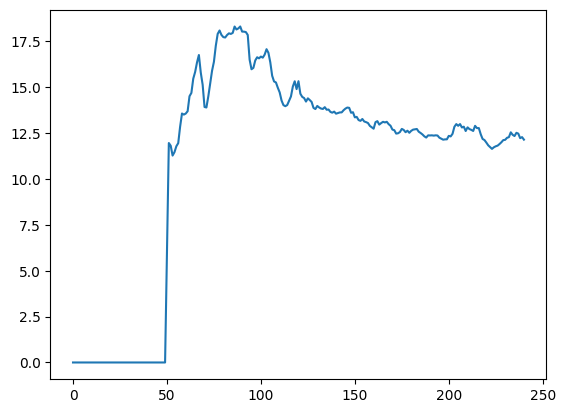

('GIF100/15.mp4', 'A kid splashing in the pool.', [100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147])


In [49]:
video_data = pickle_read('rustyjar/B14/s.pkl')[14]

plt.plot([x[1] for x in video_data], [x[0] for x in video_data])
plt.show()

print(pickle_read('rustyjar/STOCK100.pkl')[14])

In [48]:
# sus[14] = list(map(lambda x: (0, x) if x == (0, 0) else sus[14][x], range(len(sus[14])))
pickle_write('rustyjar/B14/s.pkl', sus)

In [47]:
sus[14] = list(map(lambda x: (0, x) if x < 50 else sus[14][x], range(len(sus[14]))))

In [39]:
logits = pickle_read('rustyjar/B14/s.pkl')[14]
preds = data.B14('stock100', 8)
preds[14] = 86
logits = [() if i < 50 else logits[i] for i in range(len(logits))]

sus = pickle_read('rustyjar/B14/s.pkl')
sus[14] = logits

pickle_write('jar/B14/s8.pkl', preds)
pickle_write('rustyjar/B14/s.pkl', sus)

In [24]:
s100 = pickle_read('rustyjar/STOCK100.pkl')
s100[46] = ('GIF100/47.mp4', 'A person dunks a basketball.', list(range(100, 167)))

s100t = pickle_read('rustyjar/STOCK100-testing.pkl')
s100t[46] = ('GIF100/47.mp4', list(range(100, 167)))

pickle_write(s100, 'rustyjar/STOCK100.pkl')
pickle_write(s100t, 'rustyjar/STOCK100-testing.pkl')

In [18]:
pickle_read('rustyjar/STOCK100-testing.pkl')[46]

('GIF100/47.mp4', [100, 101, 102, 103, 104])

In [9]:
data.B14('stock100', 8)[83]

np.int64(15)

In [40]:
vids = [int(x.split('.')[0]) for x in filter(lambda x: x != '.DS_Store', os.listdir('GIF100'))]

In [ ]:
shshowMetric2

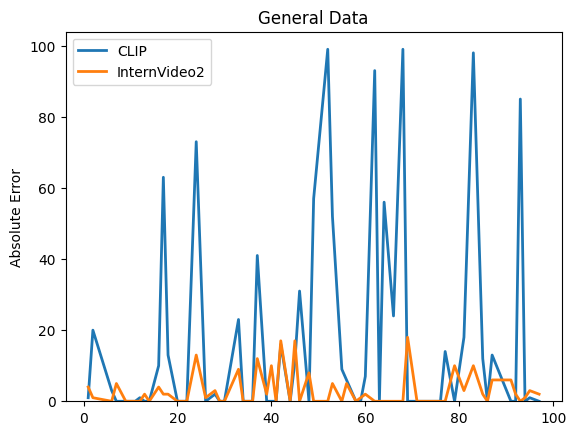

In [47]:
compare = [data.CLIP('stock100', 1), data.B14('stock100', 8)]
comp_data = data.stock100

for i in compare:
    y_vals = showMetric2(i, comp_data)
    y_vals = [y_vals[x] for x in list(filter(lambda x: x + 1 in vids, range(len(y_vals))))]
    x_vals = list(filter(lambda x: x in vids, range(1, len(comp_data) + 1)))
    plt.plot(x_vals, y_vals, linewidth=2)
    # print(x_vals)
    # print(y_vals)

plt.ylabel("Absolute Error")
plt.legend(["CLIP", "InternVideo2", "ViCLIP"], fontsize=10)
plt.title("General Data")


# plt.xticks(range(0,100, 1))
# plt.xlim(0, 20)
# k600.gca().set_position([0, 0, 1, 1])

plt.ylim(bottom = 0)
plt.savefig("general-data-compare.svg", bbox_inches = "tight")
plt.show()

In [35]:
def arenaMetric(model1, model2, data):
    model1_score = 0
    model2_score = 0
    tie_score = 0

    offsets = [find_best_offset(x, data) for x in [model1, model2]]
    pred1, pred2 = [x + offsets[0] for x in model1], [x + offsets[1] for x in model2]
    
    for idx in range(len(pred1)):
        peak1 = findClosest(pred1[idx], data[idx][1])
        peak2 = findClosest(pred2[idx], data[idx][1])
        
        if abs(pred1[idx] - peak1) < abs(pred2[idx] - peak2):
            model1_score += 1
        elif abs(pred1[idx] - peak1) > abs(pred2[idx] - peak2):
            model2_score += 1
        else:
            tie_score += 1

    data_arena = pd.DataFrame({'': ['1', '2', 'Tied'], 'Score': [model1_score, model2_score, tie_score]})
    
    print(tabulate(data_arena, headers = 'keys', tablefmt = 'fancy_grid'))

arenaMetric(data.ViCLIP('stock100', 8), data.CLIP('stock100', 1), data.stock100)

╒════╤══════╤═════════╕
│    │      │   Score │
╞════╪══════╪═════════╡
│  0 │ 1    │      47 │
├────┼──────┼─────────┤
│  1 │ 2    │      53 │
├────┼──────┼─────────┤
│  2 │ Tied │       0 │
╘════╧══════╧═════════╛


In [ ]:
import cv2
import numpy as np
from PIL import Image
from IPython.display import clear_output

def load_basketball(basketball_path, size):
    basketball = Image.open(basketball_path)
    basketball = basketball.resize((size, size), Image.LANCZOS)
    return basketball

def rotate_basketball(basketball):
    random_angle = np.random.randint(0, 360)
    return basketball.rotate(random_angle, expand=True)

def add_basketball_to_frame(frame, basketball):
    frame_pil = Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

    basketball_rotated = rotate_basketball(basketball)

    frame_width, frame_height = frame_pil.size
    basketball_width, basketball_height = basketball_rotated.size

    max_x = frame_width - basketball_width
    max_y = frame_height - basketball_height
    rand_x = np.random.randint(0, max_x)
    rand_y = np.random.randint(0, max_y)

    frame_pil.paste(basketball_rotated, (rand_x, rand_y), basketball_rotated)
    return cv2.cvtColor(np.array(frame_pil), cv2.COLOR_RGB2BGR)

def process_video(input_video_path, output_video_path, basketball_path, basketball_size):
    basketball = load_basketball(basketball_path, basketball_size)
    cap = cv2.VideoCapture(input_video_path)
    fps = cap.get(cv2.CAP_PROP_FPS)
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')

    out = cv2.VideoWriter(output_video_path, fourcc, fps, (width, height))

    count = 1
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        count += 1
        clear_output(wait=True)
        frame_with_basketball = add_basketball_to_frame(frame, basketball)

        plt.title(str(count))
        plt.imshow(frame)
        plt.show()
        out.write(frame_with_basketball)

    cap.release()
    out.release()
    cv2.destroyAllWindows()

input_video_path = 'augment/9.mp4'
output_video_path = 'augment/92.mp4'
basketball_path = 'augment_utils/cruise.png'
basketball_size = 1

process_video(input_video_path, output_video_path, basketball_path, basketball_size)

In [ ]:
import os
import shutil
from moviepy.editor import VideoFileClip

input_folder = 'gifs'
output_folder = 'GIF87'

os.makedirs(output_folder, exist_ok=True)

new_files = []
for filename in os.listdir(input_folder):
    file_path = os.path.join(input_folder, filename)
    
    if filename.endswith('.mp4'):
        shutil.copy(file_path, os.path.join(output_folder, filename))
        new_files.append(file_path)
    else:
        output_path = os.path.join(output_folder, os.path.splitext(filename)[0] + '.mp4')
        clip = VideoFileClip(file_path)
        clip.write_videofile(output_path)
        clip.close()

In [ ]:
print(sorted([int(x.split('/')[-1].split('.')[0]) for x in new_files]))